In [1]:
import numpy as np
import networkx as nx
import sympy
import matplotlib.pyplot as plt
from sympy.utilities.iterables import multiset_permutations
import cirq
import scipy
import scipy.optimize as optimize
import timeit

    

In [116]:
#defining Pauli-Matrices
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[0,1]])

"""function for construncting hamiltonian manually
INPUT:
    -N : amount of qubits
    -interactions: A list of lists that contain interactions and corresponding coupling strengths.
                Example: [['P1P2...PN',J1], ['P1P2...PN',J2],....], where P is one of {X,Y,Z,I}.
                One can leave identities out of the expression. J is the strength of the interaction and thus a number.
OUTPUT:
    -H: Hamiltonian (2^N,2^N)-d array
"""

   
def H_manual(N,interactions):
    H = np.zeros((2**N,2**N)).astype('complex128')
    for i in interactions:
        Kron = 1
        paulis = []
        positions = []
        
        #creating lists of operators and corresponding positions
        prev_int = False #value that represents if previous character was an integer
        for k in i[0]:
            if k.isdigit():
                if not prev_int:
                    positions.append(k)
                else:
                    positions[-1] = 10*positions[-1]+k
                prev_int = True
            else:
                paulis.append(k)
                prev_int = False
        

        #computes tensorproduct for every interaction
        n=0
        for j in range(N):
            
            if j+1 == int(positions[n]):
                M = eval(paulis[n])
                if n+1 < len(positions):
                    n+=1
            else:
                M = I
            Kron = np.kron(Kron,M)
            
        H += Kron*i[1]
    return H




#I thought this was useful, but it didn't really end up like that.
"""function for construncting hamiltonian with the help of a pattern
INPUT:
    -N : amount of qubits
    -operation: operation that will be applied to every qubit available
                must be a list of the form ['P1P2...PN',J], where P is one of {X,Y,Z,I}.
                One can leave identities out of the expression. J is the strength of the interaction.
    -boundary: default is 'open', which will repeat the given operation untill 
               a non-identity operation acts on the N-th qubit. One can also input 'periodic', which 
               iterates over all qubits and lets P(N+1) act on P1
OUTPUT:
    -H: Hamiltonian (2^N,2^N)-d array
"""


def H_pattern(N, operation, boundary = 'open'):
    H = np.zeros((2**N,2**N)).astype('complex128')
    #creating lists of operators and corresponding positions
    paulis = []
    positions = []
    prev_int = False
    for k in operation[0]:
        if k.isdigit():
            if not prev_int:
                positions.append(k)
            else:
                positions[-1] += k
            prev_int = True
        else:
            paulis.append(k)
            prev_int = False
        

    if boundary == 'open':
        for i in range(N-int(positions[-1])+1):
            Kron = 1
            n=0
            for j in range(N):
                
                if j+1 == int(positions[n])+i:
                    M = eval(paulis[n])
                    if n+1 < len(positions):
                        n+=1
                else:
                    M = I
                Kron = np.kron(Kron,M)
            H+= Kron*operation[1]
            

    elif boundary == 'periodic':
        for i in range(N):
            Kron = 1
            
            #Make sure periodic iterations are done correctly
            positions_periodic = ((np.array(list(map(int, positions)))+i))
            positions_periodic = np.where(positions_periodic > N, positions_periodic%N,positions_periodic)
            Tuple= list(zip(paulis,positions_periodic))
            paulis = [tuple[0] for x in np.sort(positions_periodic) for tuple in Tuple if tuple[1] == x]
            positions_periodic = np.sort(positions_periodic)
            print(positions_periodic)
            n=0

            for j in range(N):
            
                if j+1 == int(positions_periodic[n]):
                    M = eval(paulis[n])
                    if n+1 < len(positions):
                        n+=1
                else:
                    M = I
                Kron = np.kron(Kron,M)
            H+= Kron*operation[1]

            
        
    return H

                
        

In [137]:
class inter:
    def __init__(self, N, interactions, PT_order=None, P_n=None):
        self.N = N
        self.interactions = interactions
        self.PT_order = PT_order
        self.P_n = P_n
    """"
    INPUT:
    -interactions in the given format
    OUTPUT:
    -returns 2 lists of same length, on containing operations, the other containing the corresponding positions.
    """
    def split(self):
        paulis = []
        positions = []
        for i in range(len(self.interactions)):
            pauli_lst = []
            pos_lst = []

        
            #creating lists of operators and corresponding positions
            prev_int = False
            for k in self.interactions[i][0]:
                if k.isdigit():
                    if not prev_int:
                        pos_lst.append(k)
                    else:
                        pos_lst[-1] += k
                    prev_int = True
                else:
                    pauli_lst.append(k)
                    prev_int = False
            paulis.append(pauli_lst)
            positions.append(pos_lst)
        return positions, paulis
    """"
    INPUT:
    -k: list with same length of interactions, where k[i] represents how many times interactions[i] is activated
    OUTPUT:
    - state: array of length N, representing the state after applying k on ket(0).
    -a: {0,1}: 0 if resulting state is real, 1 if resulting state is imaginary.
    """
    
    def state(self, k):
        positions = self.split()[0]
        paulis = self.split()[1]
        starting_state = -np.ones(self.N)
        a = -1
        for i in range(len(k)):
            if k[i] %2 != 0:
                for j in range(len(positions[i])):
                    if paulis[i][j] == 'X':
                        starting_state[int(positions[i][j])-1] *= -1
                    elif paulis[i][j]=='Y':
                        starting_state[int(positions[i][j])-1] *= -1
                        a *=-1
                    
                        
        a = (a+1)/2
        state = (starting_state+1)/2
        return a, list(state)
        """"
    INPUT:
    -k: list with same length of interactions, where k[i] represents how many times interactions[i] is activated
    OUTPUT:
    -True or False, True if the diagrammatic corresponding to k is connected, False if the diagrammatic is disconnected.
    """
    
    def con(self,k):
        positions = self.split()[0]
        connect_on = []
        for i in range(len(k)):
                if k[i] != 0:
                    connect_on.append(positions[i])
        v = connect_on[0]
        j = 0
        while len(connect_on)!= j:
            connect_set = set(connect_on[j])
            v_set = set(v)

            if (v_set&connect_set):
                v=v+connect_on.pop(j)
                j=0
                if connect_on == []:
                    return True
            else:
                j+=1
        return False
    
    """"
    INPUT:
    -PT_order: integer, representing up till which perturbation theory one wants to consider.
    OUTPUT:
    -k_vecs: list of allowed k's. Where allowed means, with a connected diagram 
    and not with an order greater or equal to a k that produces exactly the same state.
    """
    
    def k_vecs(self):
        k_length = len(self.interactions)
        k_vecs = []
        k_vecs_allowed = []
        states = [self.state(np.zeros(k_length))]
        max_gates = min([self.PT_order, 2*k_length])
        for i in range(1,max_gates+1):
            k = []
            order = i
            if order%2==1:
                k = k+[1]
                order -= 1
            p = order/2
            k +=int(p)*[2]+int(k_length-len(k)-p)*[0]
            k_vecs.append(k)
            k_1 = k.copy()
            while 2 in k_1 and 0 in k_1:
                k_1.remove(2)
                k_1.remove(0)
                k_1+=[1,1]
                k_vecs.append(k_1)
        for i in k_vecs:
            perms = list(multiset_permutations(i))
            for j in perms:
                if self.con(j) and (self.state(j) not in states):
                    states.append(self.state(j))
                    k_vecs_allowed.append(j)
        return(k_vecs_allowed)
    """"
    INPUT:
    -PT_order: integer, representing up till which perturbation theory one wants to consider.
    OUTPUT:
    -graphs of all allowed k's up till the given order.
    """
    
    def draw_diagrammatics(self):
        vecs = self.k_vecs()
        for i in vecs:
            graph(i,self.N,self.interactions).make_graph()
            plt.show()
    def build_circuit(self):
        vecs = self.k_vecs()
        if self.P_n == 'max':
            self.P_n = len(vecs)
        pauli_operations = []
        theta = P_n*[0]
        for i in range(self.P_n):
            theta[i] = sympy.Symbol('theta_%s'%i)
            a, state = self.state(vecs[i])
            state = np.array(state)
            pauli_operations.append([QCA(self.N, state, a, theta[i]).pauli_operator()])
        return pauli_operations
    
    def print_circuit(self):
        circuit = cirq.Circuit(self.build_circuit())
        print(circuit.to_text_diagram(transpose= True))
     
    
    
    
        
    def P_tensorproducts(self):
        k = self.k_vecs()
        P_strings = []
        
        for i in range(self.P_n):
            state = self.state(k[i])
            T = 1
            complx = False
            if state[0] == 1:
                complx = True
            for j in state[1]:
                if j == 1:
                    if not complx:
                        M = Y
                        complx = True
                    else:
                        M = X
                else:
                    M = I
                T = np.kron(T,M)
            P_strings.append(T)
        return P_strings


            
        
            
            

            
            

                


        
    

In [55]:
def exact_eigen(H):
    eigen = np.linalg.eig(H)
    index = np.argmin(eigen[0])
    ground_energy = eigen[0][index]
    ground_state = np.round(eigen[1][:,index],3)
    return ground_state, ground_energy

def QCA_ansatz(theta,N,P_strings):
    matrix = np.identity(2**N).astype('complex128')
    for i in range(len(P_strings)):
        O = scipy.sparse.linalg.expm(1j*theta[i]*P_strings[i])
        matrix = O.dot(matrix)

    return matrix
    
    
def UCC_ansatz(theta,N,P_strings):
    matrix = np.zeros((2**N,2**N)).astype('complex128')
    for i in range(len(P_strings)):
        matrix += theta[i]*P_strings[i]
    matrix = scipy.sparse.linalg.expm(1j*matrix)
    return matrix

def UCC_Trot_con(theta,N,P_strings,Trot_order = 2):
    a = QCA_ansatz(theta, N, P_strings)
    matrix = a
    for i in range(Trot_order-1):
        matrix = matrix.dot(a)
    return matrix
def UCC_Trot_uncon(theta,N,P_strings, factors = None):
    matrix = QCA_ansatz(theta[:factors[0]],N, P_strings[:factors[0]])
    for i in range(1,factors[1]):
        matrix1 = QCA_ansatz(theta[i*factors[0]:(i+1)*factors[0]],N,P_strings[:factors[0]])
        matrix = matrix.dot(matrix1)
    return matrix

def Trot_error(H, N, P_strings, order):
    theta = VQa(H, ['QCA'], N, P_strings)[2]
    matrix = UCC_Trot_con(theta/order, N, P_strings, order)
    psi = np.zeros(2**N)
    psi[0]=1
    psi_final = matrix.dot(psi)
    Energy = np.transpose((np.conj(psi_final)).dot(H.dot(psi_final)))
    return(Energy)
    
    
    
def Psi(theta, ansatz, N, P_strings):
    psi = np.zeros(2**N)
    psi[0]=1
    if ansatz[0] == 'QCA':
        U = QCA_ansatz(theta, N, P_strings)
    elif ansatz[0] == 'UCC':
        U = UCC_ansatz(theta, N, P_strings)
    elif ansatz[0] == 'UCC_Trot_con':
        U = UCC_Trot_con(theta, N, P_strings,ansatz[1])
    elif ansatz[0]=='UCC_Trot_uncon':
        U = UCC_Trot_uncon(theta, N, P_strings,ansatz[1])
    else:
        U = np.identity(2**N)
        print('invalid ansatz')
            
    psi = U.dot(psi)
    return(psi)
    
def energy(theta,H,ansatz, N, P_strings):
    psi = Psi(theta,ansatz, N, P_strings)
    return np.real(np.transpose((np.conj(psi)).dot(H.dot(psi))))
    
def VQa(H, ansatz,N, P_strings,initial_guess = np.array([None])):
    if initial_guess.any() == None or len(initial_guess)!= len(P_strings):
        initial_guess = len(P_strings)*[0]
    result = optimize.basinhopping(energy, initial_guess,minimizer_kwargs = {"args":(H,ansatz,N,P_strings)}, niter = 4)#args = (H,ansatz,N,P_strings))#
    ground_state = np.round(Psi(result.x, ansatz,N, P_strings),3)
    ground_energy = result.fun
    return ground_state, ground_energy, result.x

In [5]:
"""Class that creates graph for certain k, corresponding to the given interactions

INPUT:
-k: list with same length of interactions, where k[i] represents how many times interactions[i] is activated
-interactions: A list of lists that contain interactions and corresponding coupling strengths.
Example: [['P1P2...PN',J1], ['P1P2...PN',J2],....], where P is one of {X,Y,Z,I}.
One can leave identities out of the expression. J is the strength of the interaction and thus a number.

-OUTPUT:
-graph
"""
class graph:
    def __init__(self, k, N,interactions):
        self.k= k
        self.interactions= interactions
        self.N = N
        self.G = nx.Graph()
    def Qubit_nodes(self):
        clrs = []
        for i in range(self.N):
            if inter(self.N,self.interactions).state(self.k)[1][i] == 1:
                self.G.add_node(i)
                clrs.append('black')
            else:
                self.G.add_node(i)
                clrs.append('white')
        
        nodes = list(range(self.N))
        bottom_ys = np.repeat(0,len(nodes))
        bottom_xs = np.linspace(0, 1, len(nodes))
        bottom_pos = np.column_stack([bottom_xs, bottom_ys])
        pos = dict(zip(nodes, bottom_pos))
        
        return pos, clrs
    
    def interactions_nodes(self):
        positions = inter(self.N,self.interactions).split()[0]
        paulis = inter(self.N,self.interactions).split()[1]
        connect_on = []
        multiplicity = []
        connect_on_pauli = []
        
        for i in range(len(self.k)):
            if self.k[i] != 0:
                connect_on.append(positions[i])
                connect_on_pauli.append(paulis[i])
                multiplicity.append(0)
                if self.k[i]==2:
                    connect_on.append(positions[i])
                    connect_on_pauli.append(paulis[i])
                    multiplicity.append(1)
        inter_nodes = []
        inter_pos =[]
        edges = []
        edge_clrs = []
        for j in range(len(connect_on)):
            inter_nodes.append(j+self.N)
            connect_on[j] = np.array(list(map(int, connect_on[j])))-1
            a = 0
            for z in range(len(connect_on[j])):
                edges.append((j+self.N,connect_on[j][z]))
                if connect_on_pauli[j][z] == 'X':
                    edge_clrs.append('blue')
                elif connect_on_pauli[j][z] == 'Y':
                    edge_clrs.append('red')
                else:
                    edge_clrs.append('black')
                a += self.Qubit_nodes()[0][connect_on[j][z]]/len(connect_on[j])+np.array([0,0.02])*(-1)**multiplicity[j]
            inter_pos.append(list(a))

        pos_dict = dict(zip(inter_nodes,inter_pos))
        self.G.add_nodes_from(inter_nodes)
        self.G.add_edges_from(edges)
        return pos_dict, edges, edge_clrs
    
    def make_graph(self):
        position_of_nodes, edges, edge_clrs = self.interactions_nodes()
        position_of_nodes.update(self.Qubit_nodes()[0])
        node_clrs= self.Qubit_nodes()[1]
        nx.draw_networkx_nodes(self.G, position_of_nodes, nodelist = list(range(self.N)), node_color = node_clrs, edgecolors = "black")
        nx.draw_networkx_nodes(self.G, position_of_nodes, nodelist = list(range((self.N),len(position_of_nodes))), node_color = 'black', node_shape = "s")
        nx.draw_networkx_edges(self.G, position_of_nodes,edges,edge_color = edge_clrs, width = 2)
    






/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


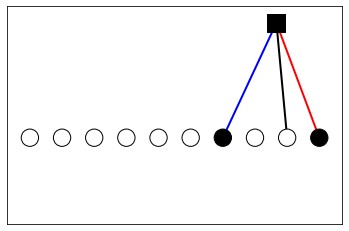

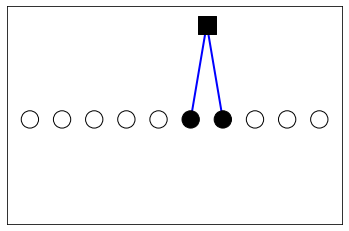

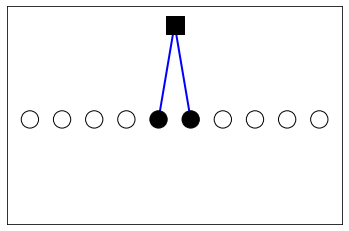

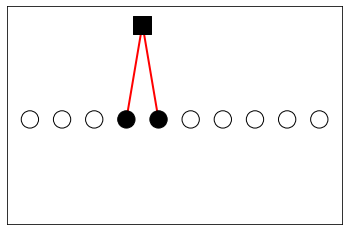

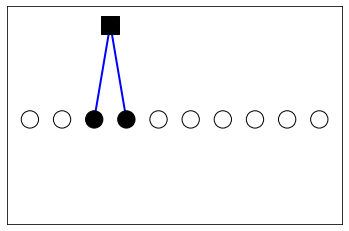

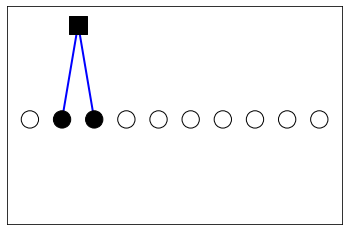

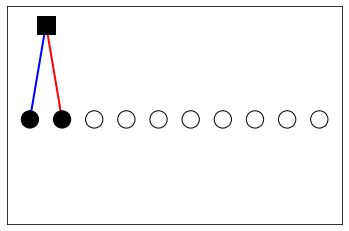

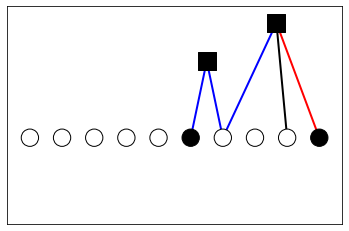

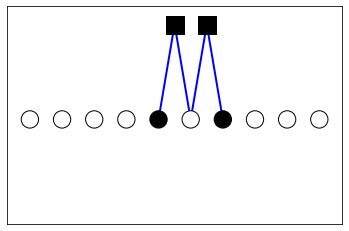

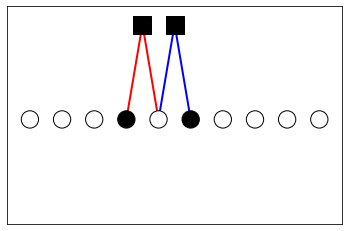

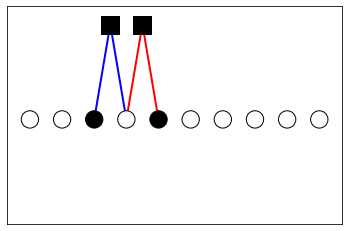

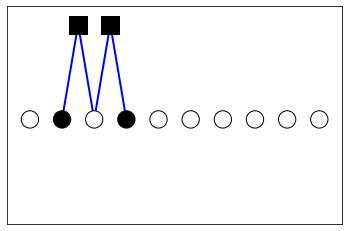

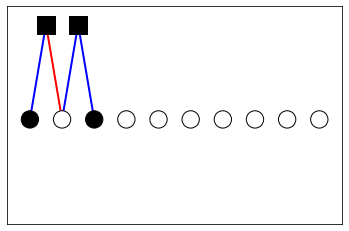

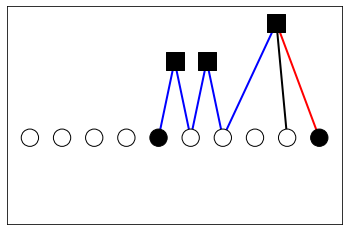

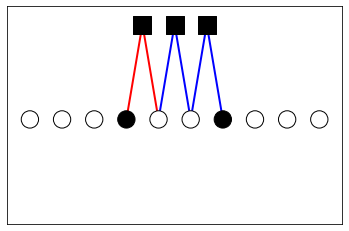

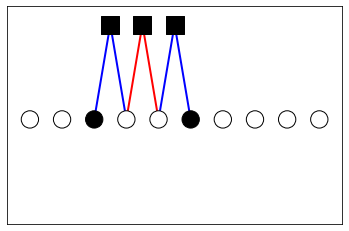

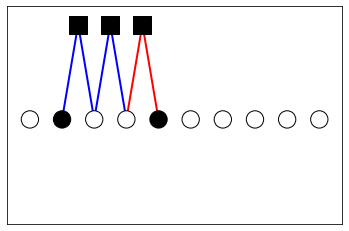

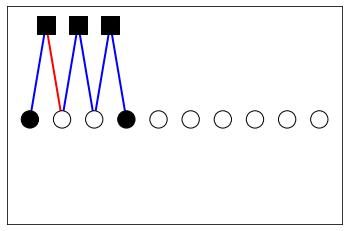

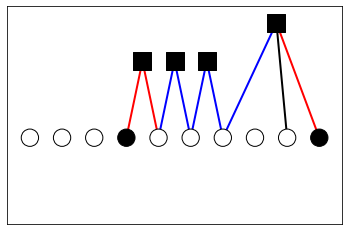

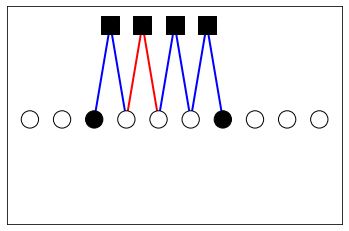

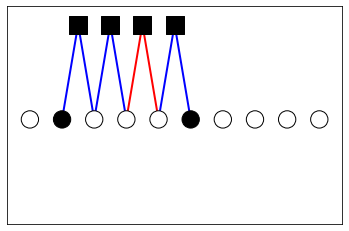

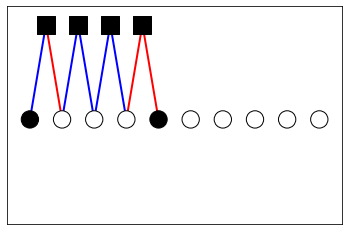

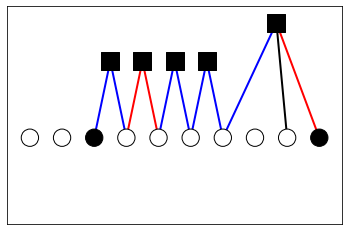

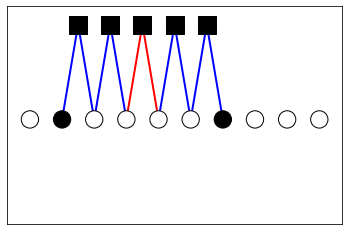

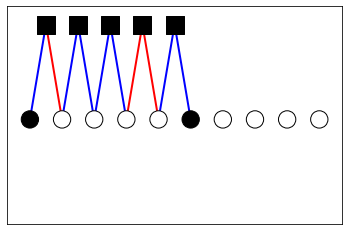

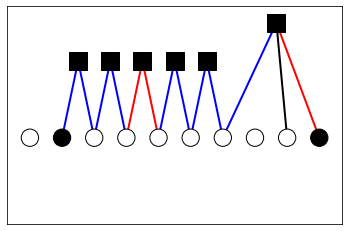

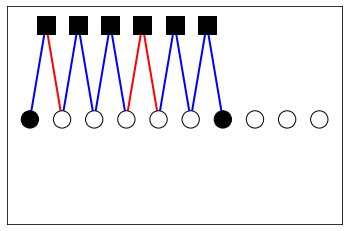

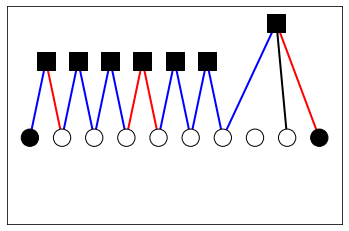

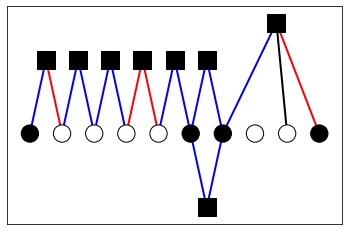

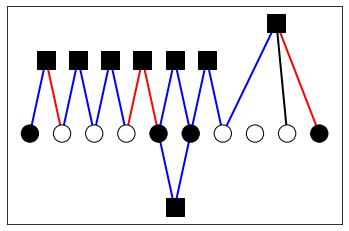

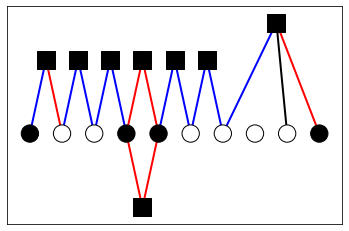

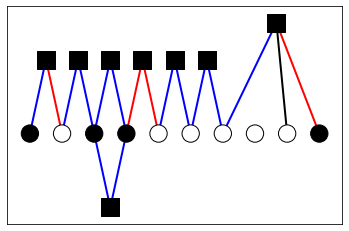

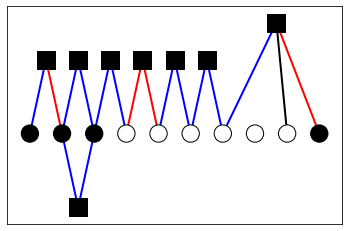

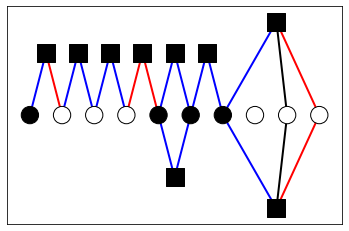

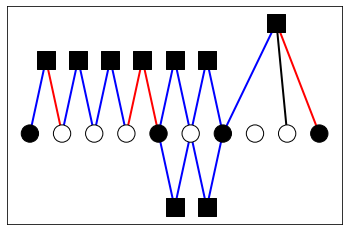

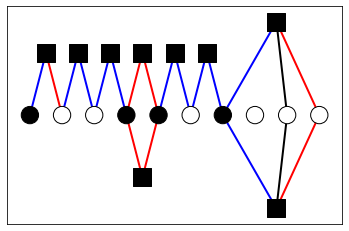

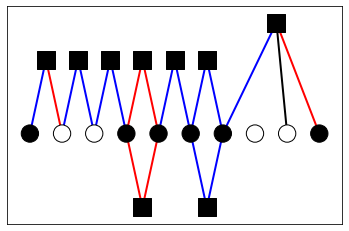

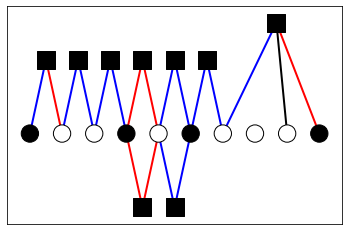

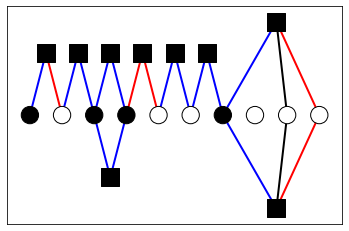

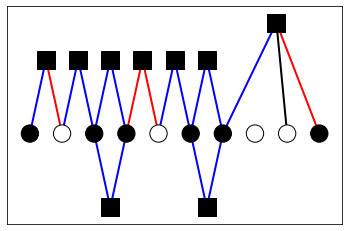

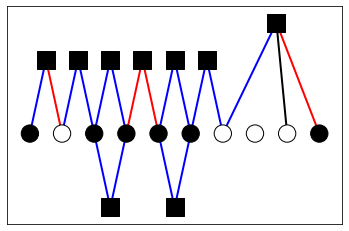

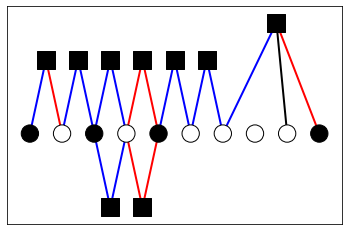

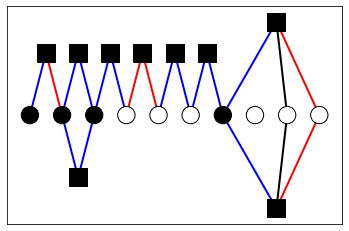

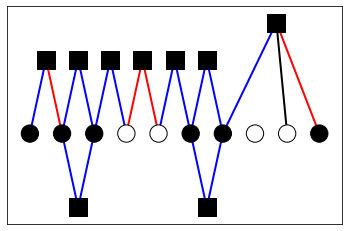

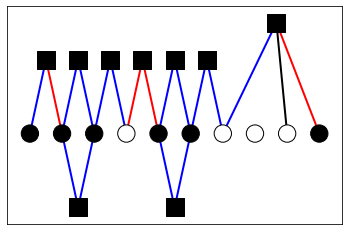

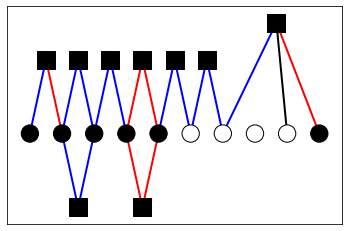

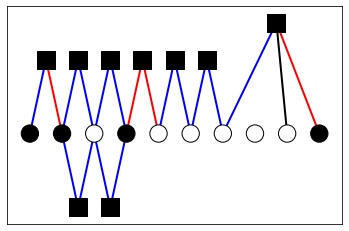

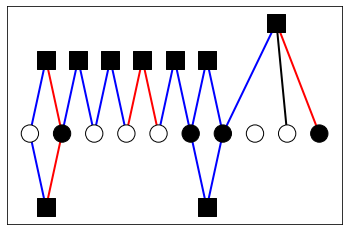

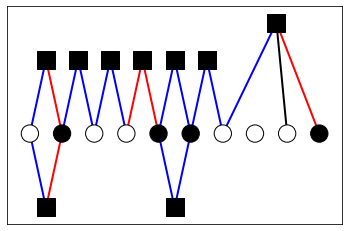

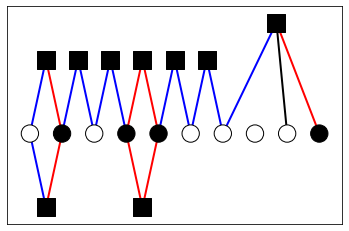

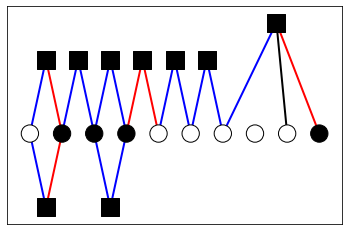

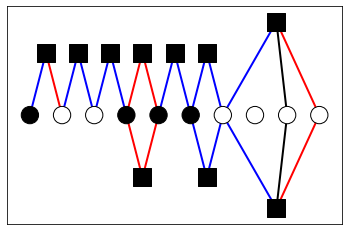

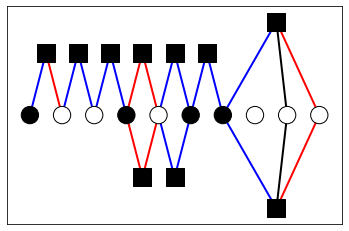

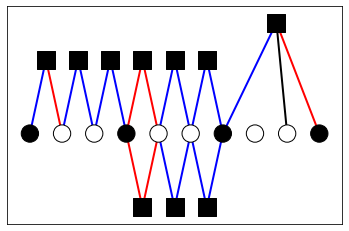

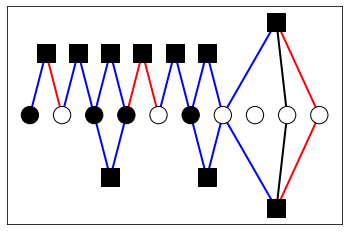

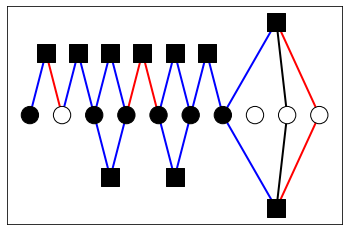

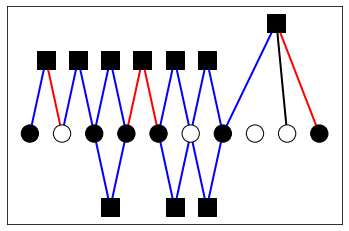

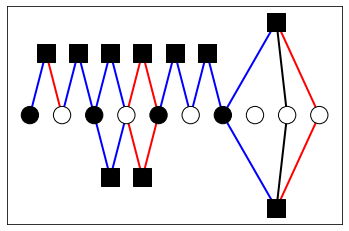

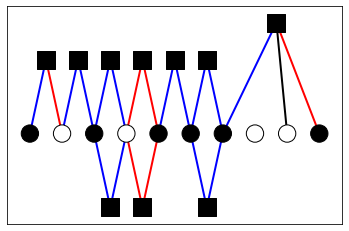

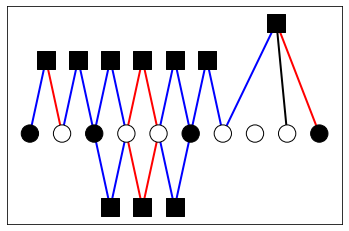

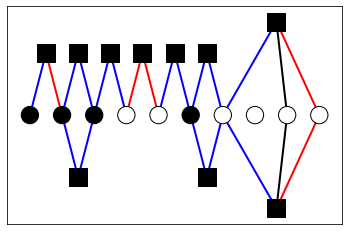

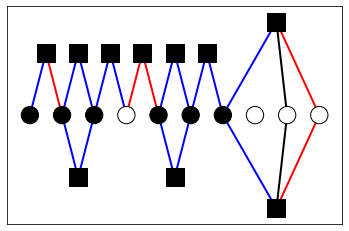

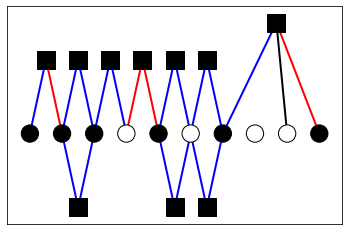

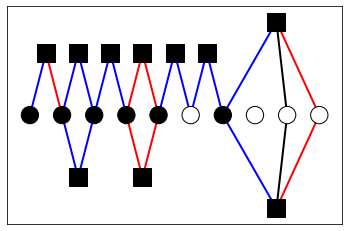

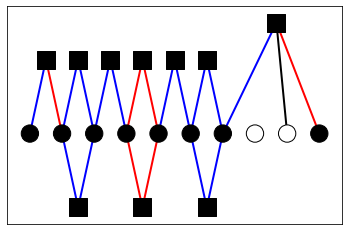

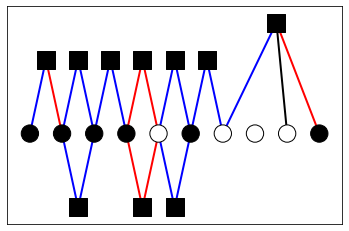

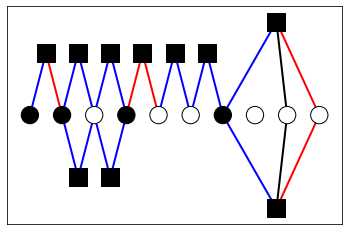

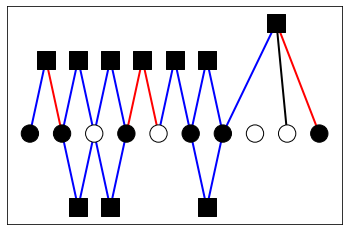

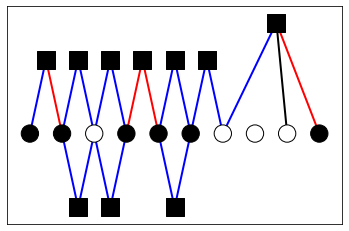

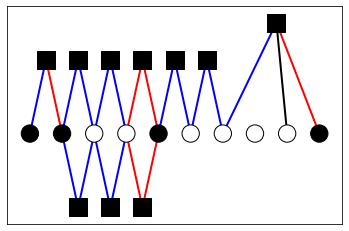

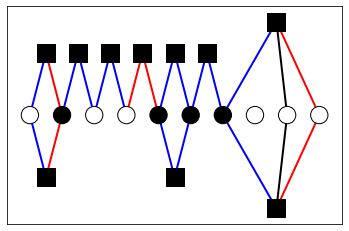

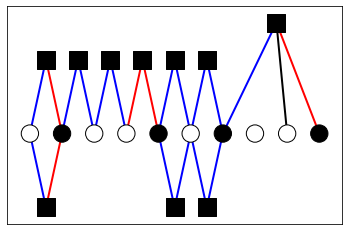

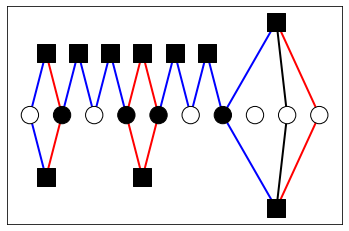

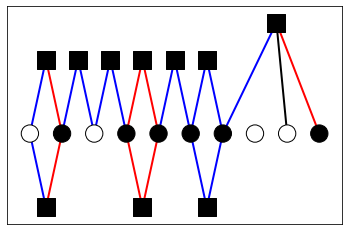

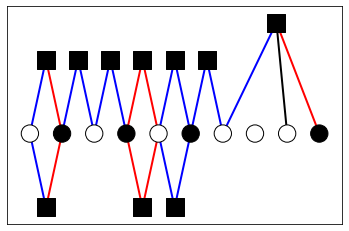

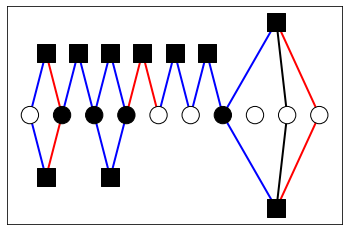

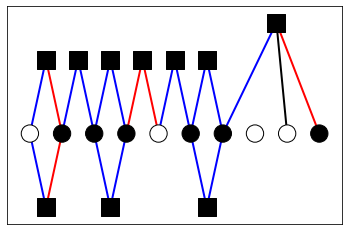

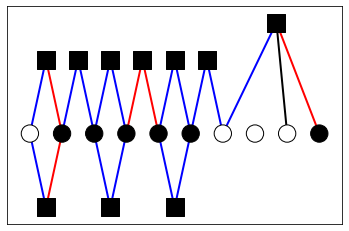

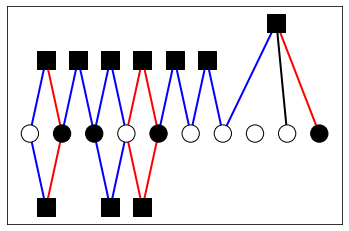

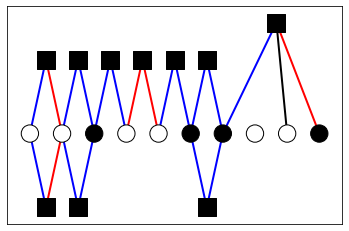

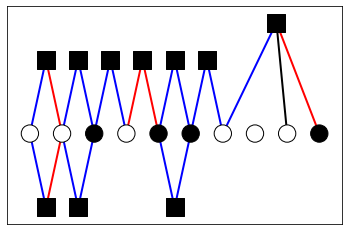

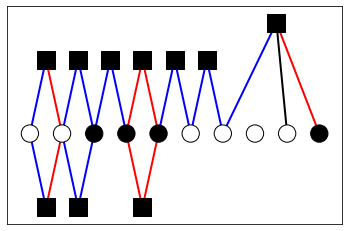

In [6]:
""""Example of graphs for given interactions

-The circles represent the qubits, black if the direction of the qubit has changed wrt to the initial state
white if unchanged.

-The squares are pictured if that interaction is activated, the lines determine to what qubits.
-A blue line represents a Pauli_X operation
-A red line represents a Pauli_Y operation
-A black line represents a Pauli_Z operation
"""""

interactions = [['X1Y2',1],['X2X3',1],['X3X4',1],['Y4Y5',1],['X5X6',1],['X6X7',1],['X7Z9Y10',1]]
N = 10 #number of qubits
PT_order = 10 #total number of interactions one wants to consider

inter(N, interactions,PT_order).draw_diagrammatics()



In [7]:
"""Class that creates a quantum circuit for certain state according to the quantum combinatorial ansatz.
INPUT:
-N: number of qubits
-State: list or array of length N, with 1's and 0's
-a: 0 or 1; 0 for real vector, 1 for complex
-theta: the angle with which must be rotated

OUTPUT:
-cirq operations that transform vector(0) to the desired state.

"""

class QCA:
    def __init__(self,N,state,a,theta):
        self.N = N
        self.state = state
        self.a = a
        self.theta = theta
        self.qubits = [cirq.GridQubit(0, j) for j in range(N)]
        self.number_of_gates = int(np.sum(state))
    def Z_string(self):
        z=[cirq.CNOT(self.qubits[self.number_of_gates-i], self.qubits[self.number_of_gates-i-1]) for i in range(1,int(self.number_of_gates))]
        return z
    def transform_to_X(self):
        t = [cirq.H(self.qubits[i]) for i in range(int(self.number_of_gates))]
        return t

    def swap(self):
        counter = 0
        gate_pos = np.transpose(np.flip(np.argwhere(self.state == 1)))
        if self.a == 0:
            swaps = [cirq.S(self.qubits[gate_pos[0][0]])]
        else:
            swaps = []
            
        for i in range(int(self.number_of_gates)):
            if self.state[i]==0:
                swaps.append(cirq.SWAP(self.qubits[i],self.qubits[gate_pos[0][counter]]))
                counter+=1
        return swaps
    def pauli_operator(self):
        total = [self.swap()]+ [self.transform_to_X()] + [self.Z_string()]
        yield total
        yield cirq.rz(2*self.theta)(self.qubits[0])
        yield cirq.inverse(total)
                
        
        
            
    

In [8]:
"""Class that calculates the groundstate of the Hamiltionan both exact and variationally.
INPUT:
-H: Hamiltionian, (2**N X 2**N) array
-circuit: cirq.Circuit object that contains the circuit that must be variationally optimized
- P_n: number of gates in the circuit
"""
class VQA:
    def __init__(self,H,circuit, P_n):
        self.H = H
        self.circuit = circuit
        self.P_n = P_n

    def Psi(self,theta):
        resolved_circuit = cirq.resolve_parameters(circuit, self.resolver(theta))
        psi = resolved_circuit.final_wavefunction()
        while len(psi) != len(self.H[:,0]):
            psi = np.kron(psi, np.array([1,0]))
        return(psi)
    def resolver(self,theta):
        angles = {}
        for i in range(self.P_n):
            angles['theta_%s'%i] = theta[i]
        return cirq.ParamResolver(angles)
            
    def energy(self, theta):
        psi = self.Psi(theta)
        return np.transpose((np.conj(psi)).dot(self.H.dot(psi)))
    def exact(self):
        eigen = np.linalg.eigh(self.H)
        index = np.argmin(eigen[0])
        ground_energy = eigen[0][index]
        ground_state = np.round(eigen[1][:,index],3)
        return ground_state, ground_energy
    def variational(self, initial_guess = None):
        if initial_guess == None:
            initial_guess = P_n*[0]
        result = optimize.minimize(self.energy, initial_guess)
        ground_state = np.round(self.Psi(result.x),3)
        ground_energy = result.fun
        print(result.x)
        return ground_state, ground_energy
    def innerproduct(self):
        a = self.variational()[0]
        b = self.exact()[0]
        return (np.conjugate(a).dot(b))



Total Hamiltonian:
[[-4.+0.j  0.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -2.+0.j  0.+1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.-1.j -2.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-1.j  0.+0.j]
 [ 0.+1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-1.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j -2.+0.j  0.+0.j  0.+0.j  0.-1.j  0.-1.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+1.j  0.+0.j  0.+0.j
   0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+1.j  0.+0.j 

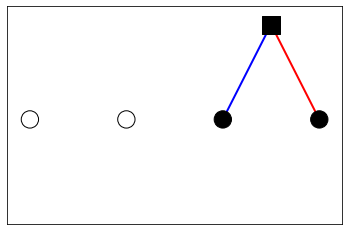

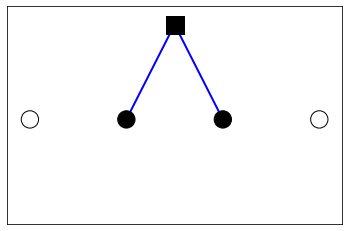

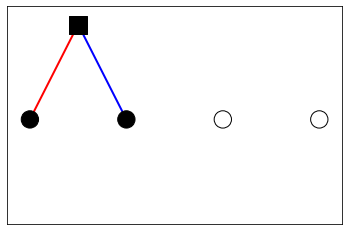

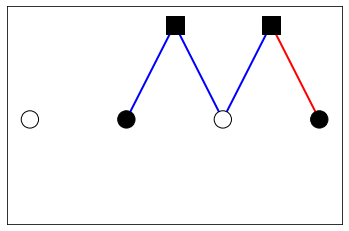

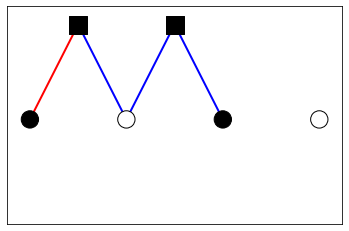

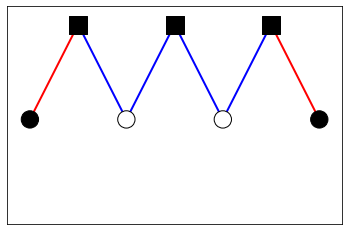

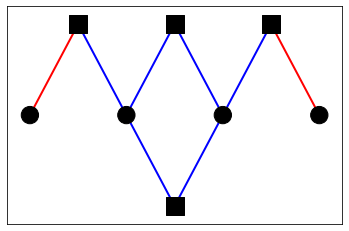


Quantum circuit that must be able to reach the groundstate:


TypeError: build_circuit() takes 1 positional argument but 3 were given

In [9]:
"""Example of all elements in the code so far"""
N = 4 
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1]]
interactions = [['Y1X2',1],['X2X3',1],['X3Y4',1]]


H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)

H = H_0 + H_1

PT_order = 4
P_n = 'max'
if P_n == 'max':
    P_n = len(inter(N, interactions,PT_order).k_vecs())

print("Total Hamiltonian:")
print(H)
print()
print("All considered diagrammatics:")
inter(N, interactions,PT_order).draw_diagrammatics()
print()
print("Quantum circuit that must be able to reach the groundstate:")
inter(N,interactions,PT_order,P_n).print_circuit()


circuit = cirq.Circuit(inter(N,interactions,PT_order,P_n).build_circuit())
eigenvector_ex , eigenvalue_ex = VQA(H,circuit,P_n).exact()
eigenvector_var , eigenvalue_var = VQA(H,circuit,P_n).variational()
print('Lowest eigenvalue of H calculated exact:')
print(eigenvalue_ex)
print()
print('Lowest eigenvalue of H calculated variationally:')
print(eigenvalue_var)
print()
print('Groundstate-vector of H calculated exact:')
print(eigenvector_ex)
print()
print('Groundstate-vector of H calculated variationally:')
print(eigenvector_var)


In [79]:
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-1],['X2X3',-1],['X3X4',-1],['X4X5',-1],['X5X6',-1]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)

H = H_0 + H_1

def performance(N, H, interactions, PT_order, ansatzes, max_gates, model):
    exact = exact_eigen(H)[1]
    ground_E = np.zeros((len(ansatzes), max_gates))
    Coupling = np.round(100*interactions[0][1]/(-1+interactions[0][1]),3)
    P_strings = inter(N, interactions, PT_order, max_gates).P_tensorproducts()
    for j in range(len(ansatzes)):
        in_guess = np.array([])
        for i in range(1,max_gates+1):
            eigenvalue_var, in_guess = VQa(H, ansatzes[j],N, P_strings[:i], np.concatenate((in_guess, np.array([0]))))[1:3]
            ground_E[j,i-1] = (eigenvalue_var-exact)/exact
        label2 = ''
        if len(ansatzes[j]) > 1:
            label2 = '_%s'%ansatzes[j][1]
        plt.plot(range(1,max_gates+1),np.real(np.log(np.real(abs(ground_E[j])))),'-o',label = "%s"%ansatzes[j][0]+label2)
    plt.title(model + " performance plot (Coupling = %s"%Coupling+'%)')
    plt.legend()
    plt.xlabel("Number of parameters (P_n)")
    plt.ylabel("$log(\epsilon)$")



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/pytho

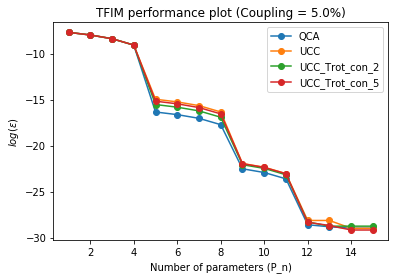

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


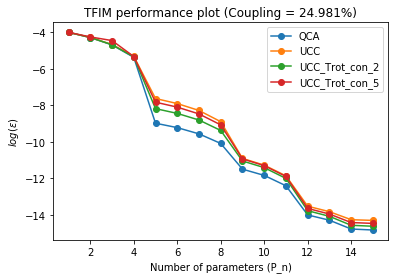

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


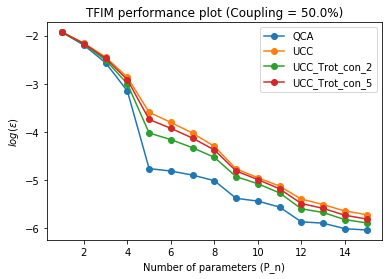

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


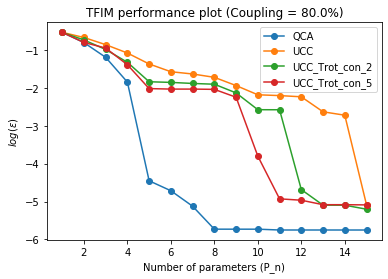

In [80]:
#TFIM for J = {5%, 25%, 50%, 80%}

Model = "TFIM"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
for J in [-0.05/0.95,-0.333,-1,-4]:
    interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J]]
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    performance(N, H, interactions, 10, [['QCA'], ['UCC'], ['UCC_Trot_con',2],['UCC_Trot_con',5]], 15, Model)
    plt.show()




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/pytho

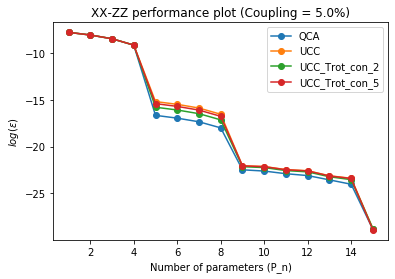

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


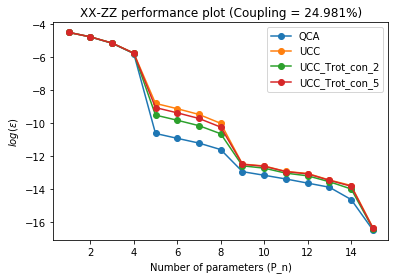

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


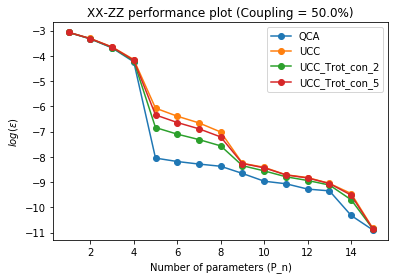

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/pytho

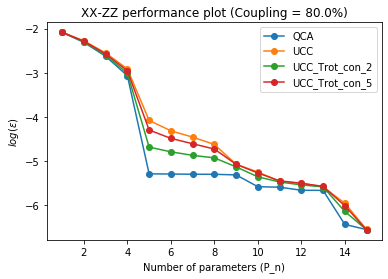

In [81]:
Model = "XX-ZZ"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
for J in [-0.05/0.95,-0.333,-1,-4]:
    interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J], ['Z1Z2',J],['Z2Z3',J],['Z3Z4',J],['Z4Z5',J],['Z5Z6',J]]
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    performance(N, H, interactions, 10, [['QCA'], ['UCC'], ['UCC_Trot_con',2],['UCC_Trot_con',5]], 15, Model)
    plt.show()

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


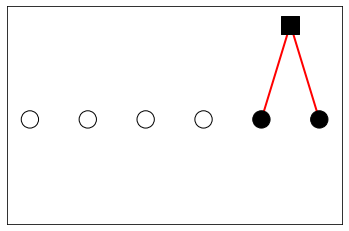

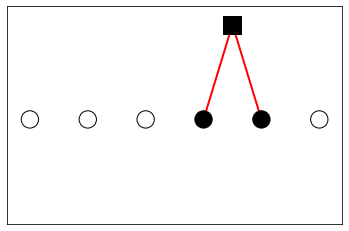

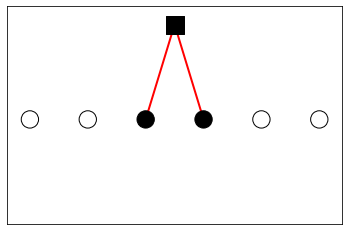

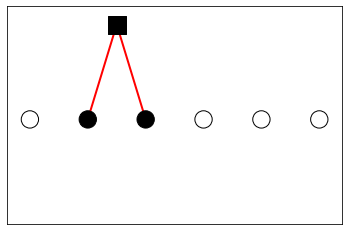

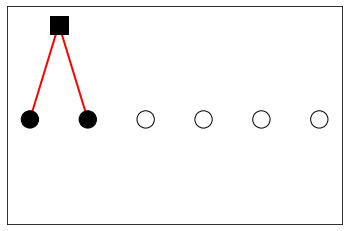

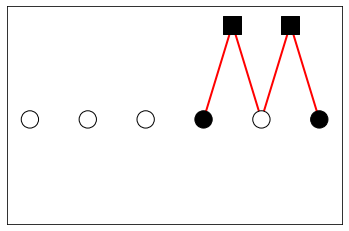

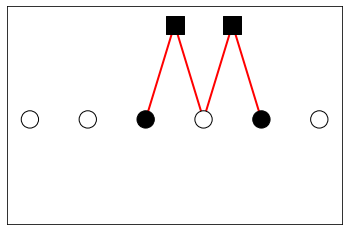

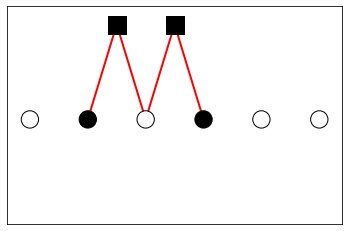

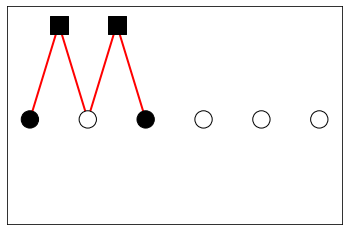

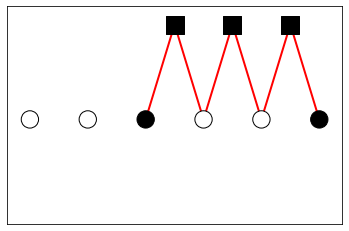

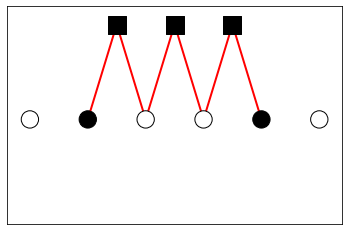

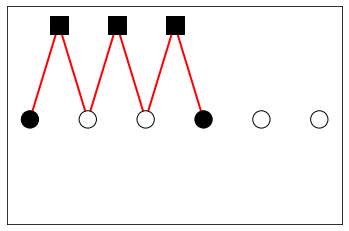

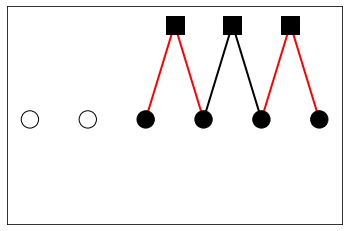

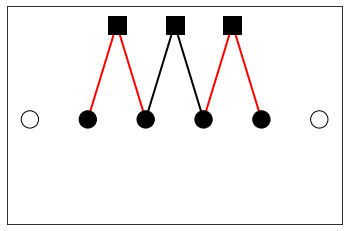

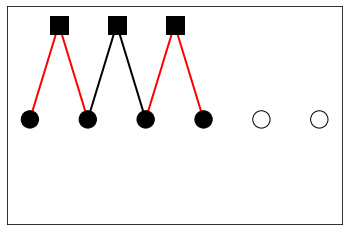

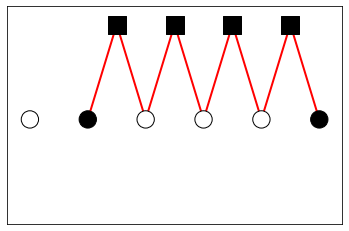

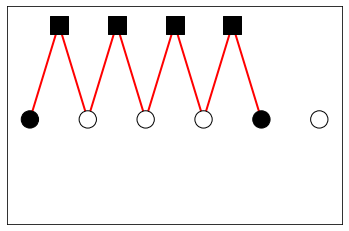

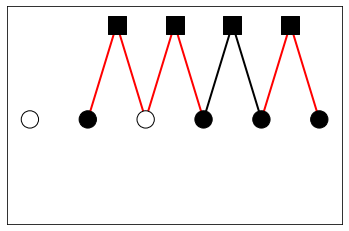

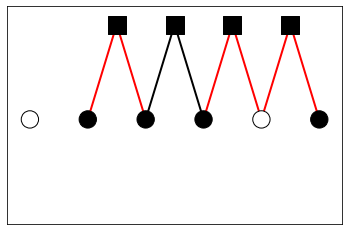

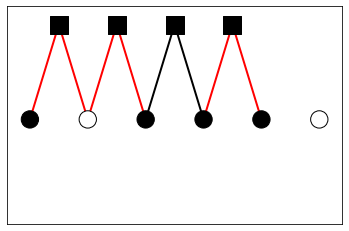

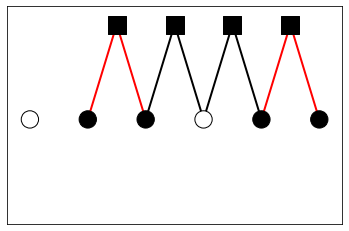

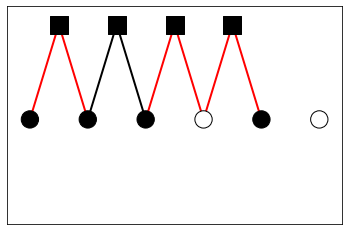

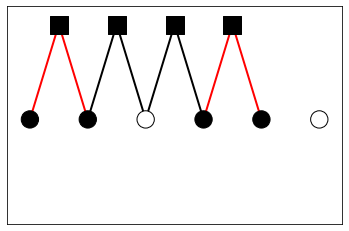

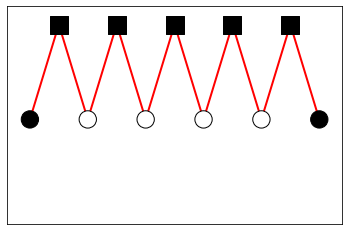

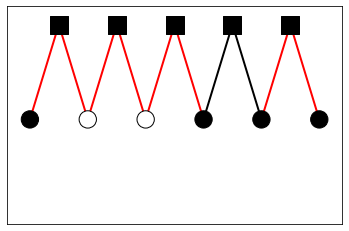

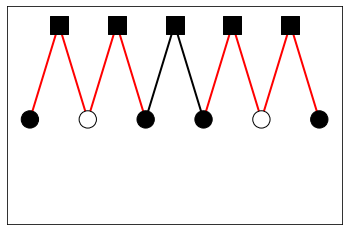

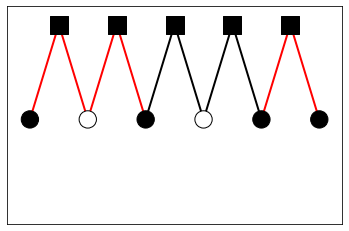

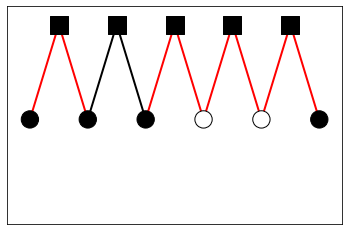

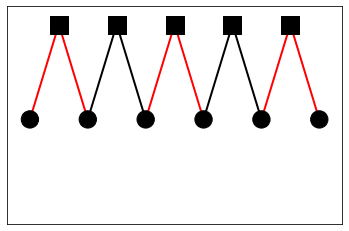

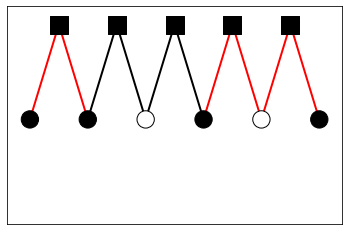

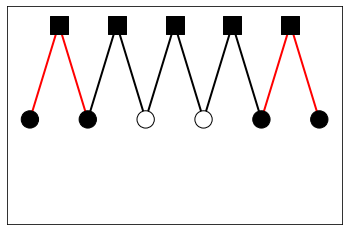

8


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero

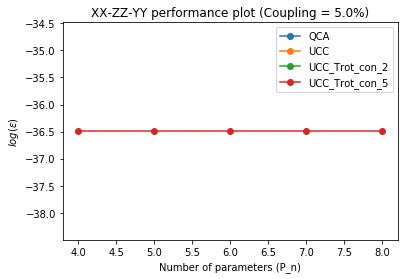

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


KeyboardInterrupt: 

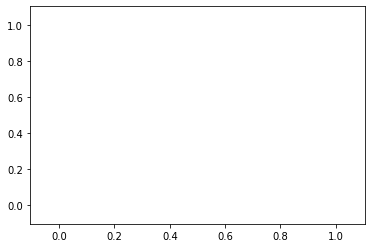

In [87]:
Model = "XX-ZZ-YY"
N = 6
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
H_0 = H_manual(N, interactions_0)
PT_order = 18
max_gates = int(np.round(len(inter(N, interactions,PT_order).k_vecs())/4,0))


for J in [-0.05/0.95,-0.333,-1,-4]:
    interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J], ['Z1Z2',J],['Z2Z3',J],['Z3Z4',J],['Z4Z5',J],['Z5Z6',J],['Y1Y2',J],['Y2Y3',J],['Y3Y4',J],['Y4Y5',J],['Y5Y6',J]]
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    performance(N, H, interactions, 10, [['QCA'], ['UCC'], ['UCC_Trot_con',2],['UCC_Trot_con',5]], max_gates, Model)
    plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(y

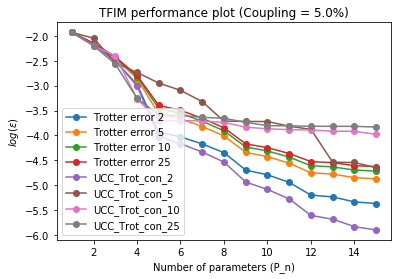

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/pytho

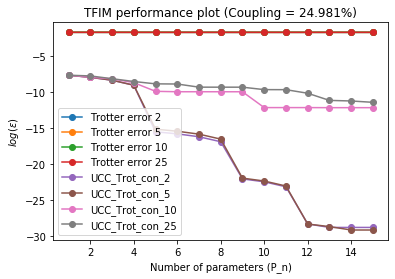

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/pytho

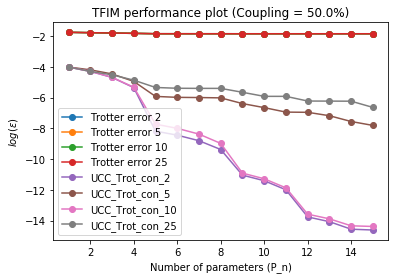

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/pytho

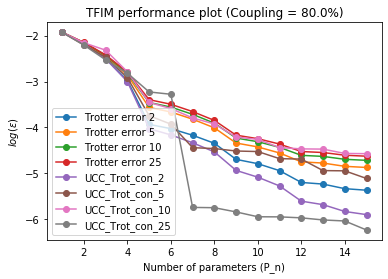

In [138]:
#TFIM for J = {5%, 25%, 50%, 80%}

Model = "TFIM"
N = 6

exact = exact_eigen(H)[1]
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-1],['X2X3',-1],['X3X4',-1],['X4X5',-1],['X5X6',-1]]
H_0 = H_manual(N, interactions_0)
max_gates = 15
PT_order = 11
P_strings = inter(N, interactions, PT_order, max_gates).P_tensorproducts()
for J in [-0.05/0.95,-0.333,-1,-4]:
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    E_trot_err_2 = (np.array([Trot_error(H, N, P_strings[:i],2) for i in range(1,max_gates+1)])-exact)/exact
    E_trot_err_5 = (np.array([Trot_error(H, N, P_strings[:i],5) for i in range(1,max_gates+1)])-exact)/exact
    E_trot_err_10 = (np.array([Trot_error(H, N, P_strings[:i],10) for i in range(1,max_gates+1)])-exact)/exact
    E_trot_err_25 = (np.array([Trot_error(H, N, P_strings[:i],25) for i in range(1,max_gates+1)])-exact)/exact
    
    interactions = [['X1X2',J],['X2X3',J],['X3X4',J],['X4X5',J],['X5X6',J]]
    plt.plot(range(1,max_gates+1), np.log(np.abs(E_trot_err_2)),'-o', label = "Trotter error 2")
    plt.plot(range(1,max_gates+1), np.log(np.abs(E_trot_err_5)),'-o', label = "Trotter error 5")
    plt.plot(range(1,max_gates+1), np.log(np.abs(E_trot_err_10)),'-o', label = "Trotter error 10")
    plt.plot(range(1,max_gates+1), np.log(np.abs(E_trot_err_25)),'-o', label = "Trotter error 25")
    performance(N, H, interactions, 10, [['UCC_Trot_con',2],['UCC_Trot_con',5],['UCC_Trot_con',10],['UCC_Trot_con',25]], max_gates, Model)
    plt.show()


/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


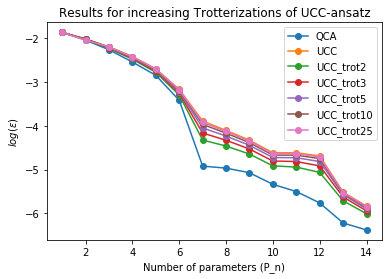

In [18]:
plt.plot(range(1,max_gates),np.log(ground_QCA),'-o',label = "QCA")
plt.plot(range(1,max_gates),np.log(ground_UCC), '-o',label = "UCC")
plt.plot(range(1,max_gates),np.log(ground_UCC_trot), '-o',label = "UCC_trot2")
plt.plot(range(1,max_gates),np.log(abs(ground_UCC_trot3)), '-o',label = "UCC_trot3" )
plt.plot(range(1,max_gates),np.log(abs(ground_UCC_trot5)), '-o',label = "UCC_trot5")
plt.plot(range(1,max_gates),np.log(abs(ground_UCC_trot10)),'-o', label = "UCC_trot10")
plt.plot(range(1,max_gates),np.log(abs(ground_UCC_trot25)),'-o', label = "UCC_trot25")
plt.xlabel("Number of parameters (P_n)")
plt.ylabel("$log(\epsilon)$")
plt.title("Results for increasing Trotterizations of UCC-ansatz")
plt.legend()
plt.savefig("Trotter_steps")
plt.show()

$\textbf{Pattern in graph}$

In the graph above, one can see the ground-state energy estimations aproach the actual ground-state energy with steps as more gates are added. From the $6^{th}$ to the $7^{th}$ value of P_n, there is a little drop in the graph. This can be explained as follows: Since the system has 8 qubits and 7 first-order interactions, the ground-state up to the first order in perturbation theory can be reached with the help of 7 gates/parameters. But with anything less than 7 gates, there is no guarentee that the first-order ground state can be reached. The $8^{th}$ gate will give a contribution of second order to the ground state, and thus will give relatively less improvement compared to the gates corresponding to a first-order contribution.

$\textbf{Comparison ansatzes}$

One can see that the QCA ansatz appears to work the best of all ansatzes.


[-8.236067977498628]
[-8.236067977498628, -8.48443533176566]
[-8.236067977498628, -8.48443533176566, -8.734230848278902]


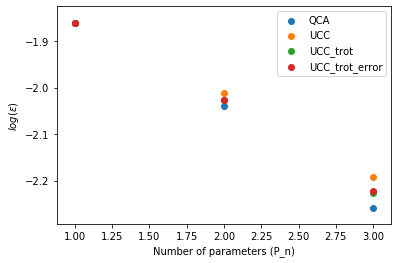

In [181]:
N = 8
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1],['Z7',-1],['Z8',-1]]
interactions = [['Y1X2',1],['X2X3',1],['X3Y4',1],['X4X5',1],['X5X6',1],['X6X7',1],['X7X8',1]]

H_0 = H_manual(N,interactions_0)
H_1 = H_manual(N,interactions)
H = H_0 + H_1

PT_order = 4
P_n = 'max'
if P_n == 'max':
    P_n = len(inter(N, interactions,PT_order).k_vecs())

exact = exact_eigen(H)[1]
ground_QCA = []
ground_UCC = []
ground_UCC_trot = []
ground_UCC_trot_err = []
max_gates = 4
P_strings = inter(N, interactions, PT_order, P_n).P_tensorproducts()
in_guess = np.array([])
for i in range(1,max_gates):
    eigenvalue_var, in_guess = VQa(H, ['QCA'],N, P_strings[:i], np.concatenate((in_guess, np.array([0]))))[1:3]
    eigenvalue_var_ucc = VQa(H, ['UCC'], N, P_strings[:i], in_guess)[1]
    eigenvalue_var_ucc_Trot = VQa(H, ['UCC_Trot_con',2], N, P_strings[:i], in_guess)[1]
    eigenvalue_var_ucc_Trot_err = Trot_error(H, N, P_strings[:i], 2)
    ground_QCA.append(eigenvalue_var)
    ground_UCC.append(eigenvalue_var_ucc)
    ground_UCC_trot.append(eigenvalue_var_ucc_Trot)
    ground_UCC_trot_err.append(eigenvalue_var_ucc_Trot_err)

    print(ground_QCA)

ground_QCA = (np.array(ground_QCA)-exact)/exact
ground_UCC = (np.array(ground_UCC)-exact)/exact
ground_UCC_trot = (np.array(ground_UCC_trot)-exact)/exact 
ground_UCC_trot_err = (np.array(ground_UCC_trot_err)-exact)/exact
plt.scatter(range(1,max_gates),np.log(abs(ground_QCA)),label = "QCA")
plt.scatter(range(1,max_gates),np.log(abs(ground_UCC)),label = "UCC")
plt.scatter(range(1,max_gates),np.log(abs(ground_UCC_trot)),label = "UCC_trot")
plt.scatter(range(1,max_gates),np.log(abs(ground_UCC_trot_err)),label = "UCC_trot_error")

plt.legend()
plt.xlabel("Number of parameters (P_n)")
plt.ylabel("$log(\epsilon)$")
plt.show()


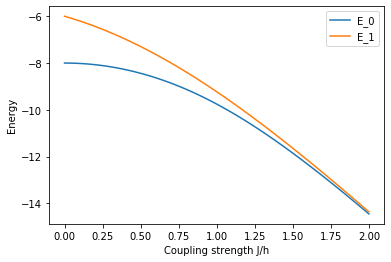

In [83]:
a = []
b = []
N = 8
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1],['Z7',-1],['Z8',-1]]

for i in np.linspace(0,2,100):
    interactions = [['Y1X2',i],['X2X3',i],['X3Y4',i],['X4X5',i],['X5X6',i],['X6X7',i],['X7X8',i]]
    H_0 = H_manual(N, interactions_0)
    H_1 = H_manual(N, interactions)
    H = H_0 + H_1
    exact_0 = np.linalg.eigh(H)[0][0]
    exact_1 = np.linalg.eigh(H)[0][1]
    
    a.append(exact_0)
    b.append(exact_1)
plt.plot(np.linspace(0,2,100),a,label = "E_0")
plt.plot(np.linspace(0,2,100),b, label = "E_1")
plt.legend()
plt.xlabel("Coupling strength J/h")
plt.ylabel("Energy")
plt.show()


In [20]:
def angles(N, H , ansatz, P_strings, max_gates):
    angless = np.zeros((max_gates, max_gates))
    for i in range(1,max_gates+1):
        a = (VQa(H, ansatz,N, P_strings[:i])[2]%(2*np.pi))
        a = np.where(a > np.pi, a-2*np.pi, a)
        angless[i-1,:i] = a
        print(angless[i-1,:i])
    for i in range(max_gates):
        plt.plot(np.array(list(range(1,max_gates+1))),angless[:,i],'-o', label = "gate %s"%(i+1))
    plt.legend()
    plt.title(ansatz[0])
    plt.xlabel('Number of gates')
    plt.ylabel('$\theta$ in radians')
    plt.show()


[0.23182329]
[0.24407338 0.24407338]
[0.24554489 0.25790358 0.24554475]
[0.24573067 0.25958882 0.25958885 0.24573067]
[0.24575417 0.25980168 0.26130253 0.25980167 0.24575419]
[0.24575722 0.25982779 0.26151998 0.26151878 0.25982891 0.24575811]
[0.24575855 0.25983268 0.26154651 0.26173645 0.26154732 0.25983195
 0.24575761]
[ 0.24795753  0.25171125  0.25776122  0.26126005  0.26148634  0.25982464
  0.24575676 -0.02540315]


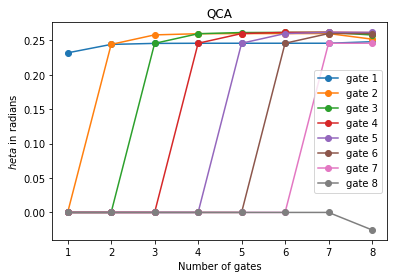

In [21]:
N = 8
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1],['Z7',-1],['Z8',-1]]
interactions = [['X1X2',1],['X2X3',1],['X3X4',1],['X4X5',1],['X5X6',1],['X6X7',1],['X7X8',1]]
H_0 = H_manual(N, interactions_0)
H_1 = H_manual(N, interactions)

H = H_0 + H_1
P_strings = inter(N, interactions,4,16).P_tensorproducts()
angles(N, H, ['QCA'], P_strings, 8)

In [24]:
a = np.array([[1,2,3],[4,5,6]])
c = (a - 2) / 2
print(c)

[[-0.5  0.   0.5]
 [ 1.   1.5  2. ]]


In [126]:
interactions_0 = [['Z1',-1],['Z2',-1],['Z3',-1],['Z4',-1],['Z5',-1],['Z6',-1]]
interactions = [['X1X2',-1],['X2X3',-1],['X3X4',-1],['X4X5',-1],['X5X6',-1]]
H_0 = H_manual(N, interactions_0)
max_gates = 15
PT_order = 11
print(inter(N, interactions, PT_order).split())

([['1', '2'], ['2', '3'], ['3', '4'], ['4', '5'], ['5', '6']], [['X', 'X'], ['X', 'X'], ['X', 'X'], ['X', 'X'], ['X', 'X']])


array([[ 0.+0.j,  0.-0.j,  0.-0.j, -1.+0.j],
       [ 0.+0.j,  0.+0.j,  1.-0.j,  0.-0.j],
       [ 0.+0.j,  1.-0.j,  0.+0.j,  0.-0.j],
       [-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]])

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])